In [ ]:
import json
from datetime import datetime
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import cv2
import os
import numpy as np
from torchvision import models
from tqdm import tqdm

In [37]:
def convert_time(t):
    dt = datetime.strptime(t, "%H:%M:%S")
    return dt.hour * 3600 + dt.minute * 60 + dt.second

In [38]:
def calculate_diff_time(start, end):
    start_seconds = convert_time(start)
    end_seconds = convert_time(end)
    diff_seconds = end_seconds - start_seconds
    return diff_seconds

При осмотре датасета были найдены ошибки в разметке: на некоторых видео время конца заставки было раньше, чем время заставки (примеры на изображениях), поэтому была написана функция ниже, которая вычисляет разницу во времени, и если она меньше 0, то выводит название видео. Затем вручную были исправлены все ошибки.

<a href="https://imgbb.com/"><img src="https://i.ibb.co/spy1C3wb/image.png" alt="image" border="0"></a>
<a href="https://imgbb.com/"><img src="https://i.ibb.co/Fb0Dqnmc/2.png" alt="2" border="0"></a>

In [4]:
with open("labels_json/train_labels.json", "r", encoding='utf-8') as f:
    train_labels = json.load(f)

# поиск ошибок в разметке когда время начала больше времени конца
for video, info in train_labels.items():
    diff_time = calculate_diff_time(info['start'], info['end'])
    if diff_time < 0:
        print(f"{video} - {info['name']}")

In [ ]:
class IntroClipDataset(Dataset):
    def __init__(self, video_dir, annotation_path, clip_len=16):
        self.video_dir = video_dir
        self.clip_len = clip_len
        self.clips = []

        with open(annotation_path, "r", encoding='utf-8') as f:
            self.annotations = json.load(f)


        self._prepare_clips()

    def _prepare_clips(self):
    
        for video, info in self.annotations.items():
            video_path = os.path.join(self.video_dir, video, video + ".mp4")
            cap = cv2.VideoCapture(video_path)
            fps = cap.get(cv2.CAP_PROP_FPS)
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

            intro_start = convert_time(info["start"])
            intro_end = convert_time(info["end"])
            duration = int(total_frames / fps)

            # создаём клипы по всему видео
            for start in range(0, duration - self.clip_len - 1):
                end = start + self.clip_len
                if end > duration:
                    end = duration
                self.clips.append({
                    "video": video_path,
                    "start": start,
                    "end": end,
                    "intro_start": intro_start,
                    "intro_end": intro_end,
                })

            cap.release()
            

    def __len__(self):
        return len(self.clips)

    def __getitem__(self, idx):
        item = self.clips[idx]
        cap = cv2.VideoCapture(item["video"])
        frames = []
        labels = []

        cap.set(cv2.CAP_PROP_POS_MSEC, item["start"] * 1000)

        for sec in range(item["start"], item["end"]):
            cap.set(cv2.CAP_PROP_POS_MSEC, sec * 1000)
            ret, frame = cap.read()
            if not ret:
                break
            label = 1 if item["intro_start"] <= sec < item["intro_end"] else 0
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = cv2.resize(frame, (112,112))
            frame = frame / 255.0  # нормализация [0, 1]
            frames.append(frame)
            labels.append(label)

        cap.release()

        if len(frames) == 0:
            print(f"[WARNING] Пустой клип: {item['video']} секунд {item['start']}–{item['end']}")
            return self.__getitem__((idx + 1) % len(self.clips))

        # [T, H, W, C] → [C, T, H, W]
        frames = np.stack(frames)  # T, H, W, C
        frames = frames.transpose(3, 0, 1, 2)
        return torch.tensor(frames, dtype=torch.float32), torch.tensor(labels, dtype=torch.long)

In [56]:
# Визуализация клипов
def show_clip(clip_tensor, label=None):
    """
    Показывает все кадры в одном клипе на одной строке.
    clip_tensor: [C, T, H, W] (обычно [3, 16, 112, 112])
    """
    clip = clip_tensor.permute(1, 2, 3, 0).numpy()  # [T, H, W, C]
    num_frames = clip.shape[0]

    plt.figure(figsize=(num_frames*5, 5))
    for i in range(num_frames):
        plt.subplot(1, num_frames, i + 1)
        plt.imshow(clip[i])
        plt.axis('off')
    title = f"Label: {label}" if label is not None else "Clip"
    plt.suptitle(title)
    plt.show()

В качестве CNN модели была выбрана ResNet50 с предобученными весами на датасете ImageNet, чтобы не обучать модель с нуля, но получить хороший результат.

Для отслеживания временных прихнаков выбрана LSTM c двойным направлением, так как важнопонимать не только когда началась заставка, но и когда закончилась.

И последний слой - это полносвязный слой для классификации каждого кадра.

In [57]:
class MyModel(torch.nn.Module):
    def __init__(self, num_classes=2):
        super(MyModel, self).__init__()
        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        self.cnn = torch.nn.Sequential(*list(resnet.children())[:-1]) 

        for param in self.cnn.parameters():
            param.requires_grad = False

        self.lstm = torch.nn.LSTM(input_size=2048, hidden_size=512, num_layers=2, batch_first=True, bidirectional=True)

        self.fc = torch.nn.Linear(512 * 2, num_classes)

    def forward(self, x):
        batch_size, channels, time, height, width = x.size()
        x = x.view(batch_size * time, channels, height, width)
        x = self.cnn(x)
        x = x.view(batch_size, time, -1)
        x, _ = self.lstm(x)
        x = self.fc(x)
        return x 


In [ ]:
def train(model, train_dataloader, val_dataloader, num_epochs=10, wandb_project=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    model.to(device)
    
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    if wandb_project:
        import wandb
        wandb.init(project=wandb_project)
        wandb.watch(model)

    for epoch in range(num_epochs):
        model.train()
        for clips, labels in tqdm(train_dataloader):
            clips, labels = clips.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(clips)            
            loss = criterion(outputs.view(-1, outputs.size(-1)), labels.view(-1))
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            model.eval()
            val_loss = 0.0
            correct = 0
            total = 0
            accuracy = 0.0
            for val_clips, val_labels in tqdm(val_dataloader):
                val_clips, val_labels = val_clips.to(device), val_labels.to(device)
                val_outputs = model(val_clips)
                val_loss += criterion(val_outputs.view(-1, val_outputs.size(-1)), val_labels.view(-1)).item()
                _, predicted = torch.max(val_outputs, -1)
                total += val_labels.size(0)
                correct += (predicted == val_labels).sum().item()

            val_loss = val_loss / len(val_dataloader)
            accuracy = correct / total
        
        if wandb_project:
            wandb.log({
                "epoch": epoch + 1,
                "train_loss": loss.item(),
                "val_loss": val_loss,
                "accuracy": accuracy
            })

        print(f"Epoch {epoch + 1}/{num_epochs}, Trian Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}")
    
    torch.save(model.state_dict(), "intro_model.pth")
    return model


In [98]:
# Создание датасетов и загрузчиков
train_dataset = IntroClipDataset("data_train_short", "labels_json/train_labels.json", clip_len=10)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

val_dataset = IntroClipDataset("data_val_short", "labels_json/val_labels.json", clip_len=10)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

test_dataset = IntroClipDataset("data_test_short", "labels_json/test_labels.json", clip_len=10)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

torch.Size([4, 3, 10, 112, 112])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


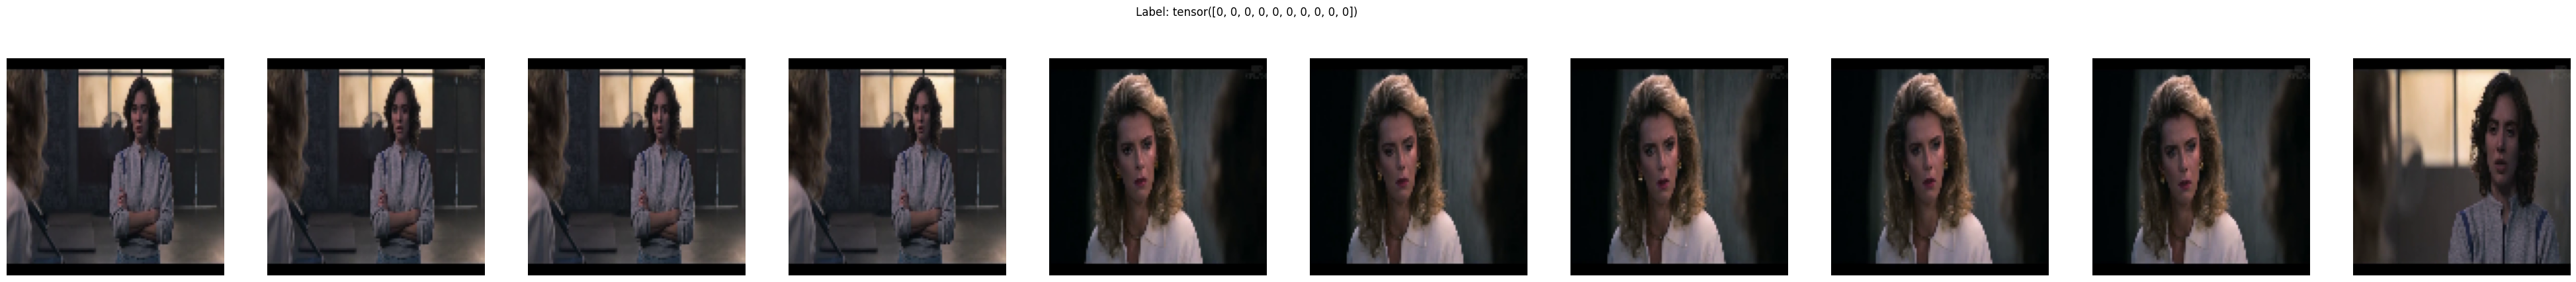

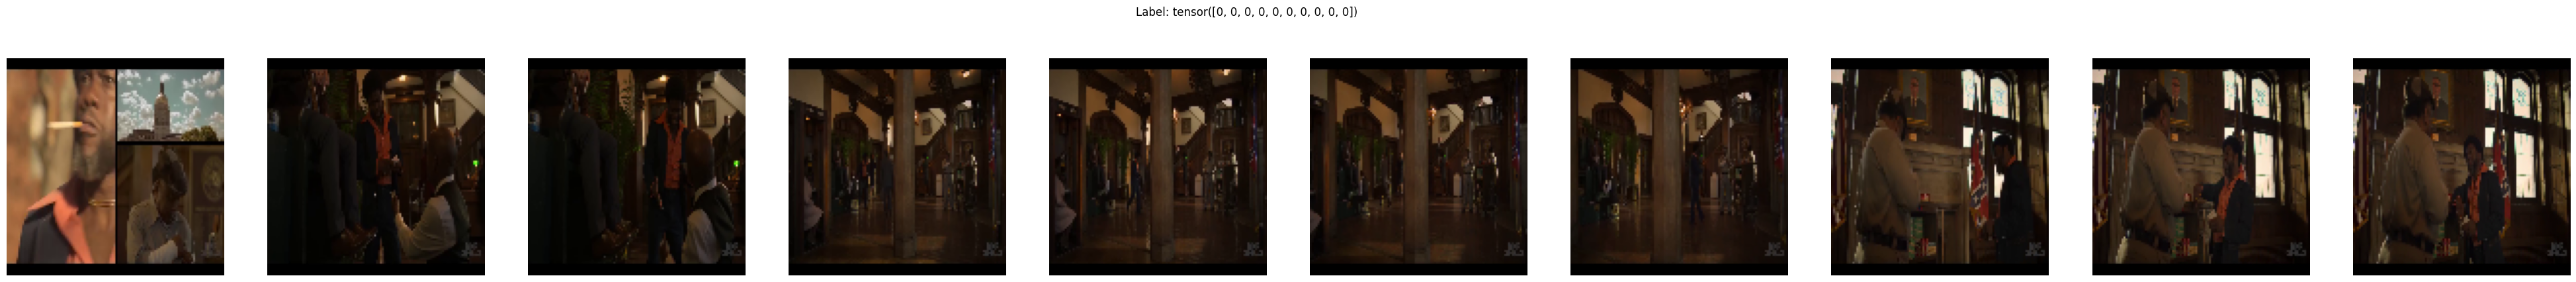

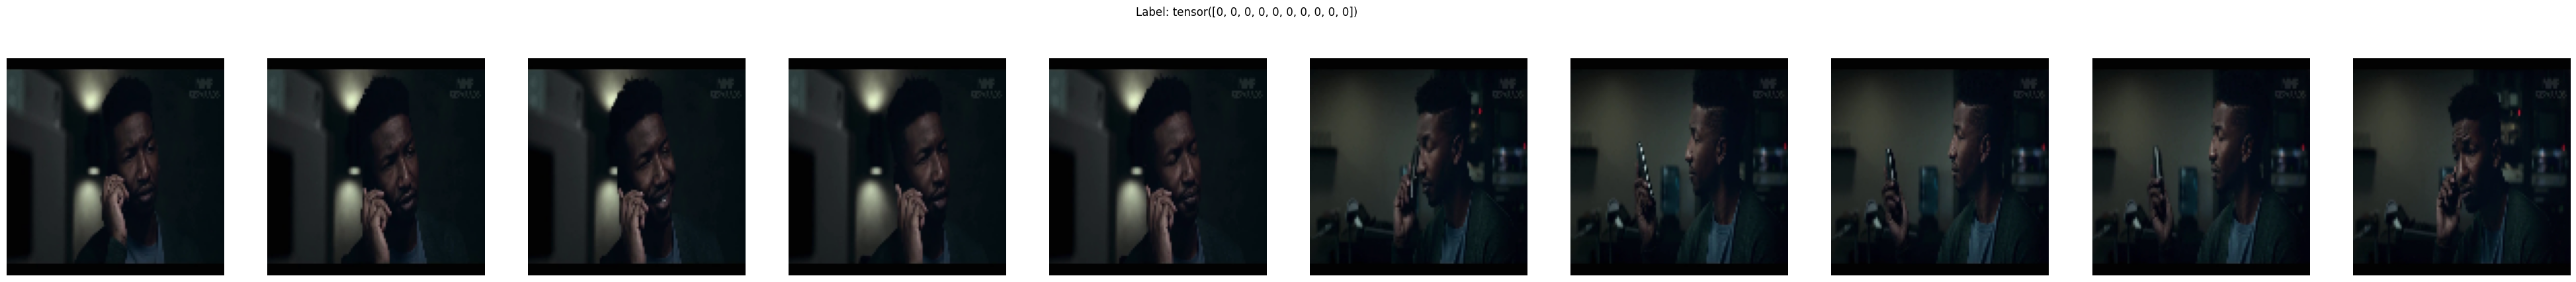

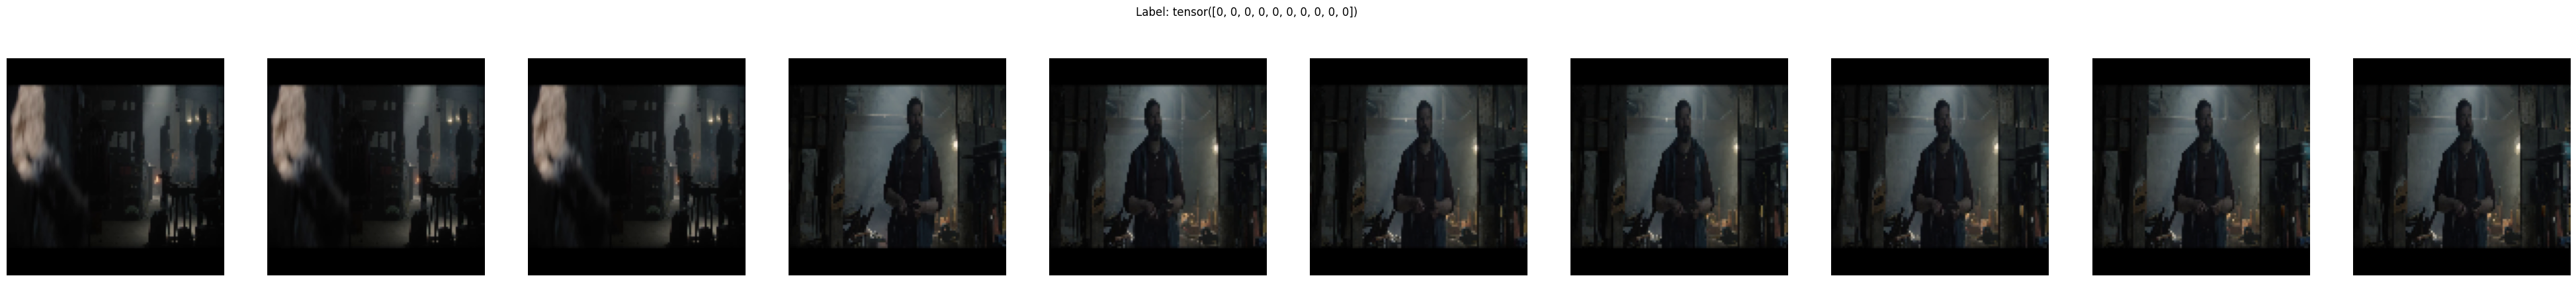

In [94]:
for clips, labels in train_loader:
    print(clips.shape)  # [B, C, T, H, W]
    print(labels)
    for i in range(clips.shape[0]):
        show_clip(clips[i], labels[i])
    break

In [99]:
model = MyModel(num_classes=2)
model = train(model, train_loader, val_loader, num_epochs=1, wandb_project="intro_detection")

Using device: cuda


  0%|          | 14/42022 [00:58<36:48:41,  3.15s/it]

[WARNING] Пустой клип: data_train_short\-220020068_456239859\-220020068_456239859.mp4 секунд 796–806
[WARNING] Пустой клип: data_train_short\-220020068_456239859\-220020068_456239859.mp4 секунд 797–807
[WARNING] Пустой клип: data_train_short\-220020068_456239859\-220020068_456239859.mp4 секунд 798–808
[WARNING] Пустой клип: data_train_short\-220020068_456239859\-220020068_456239859.mp4 секунд 799–809
[WARNING] Пустой клип: data_train_short\-220020068_456239859\-220020068_456239859.mp4 секунд 800–810
[WARNING] Пустой клип: data_train_short\-220020068_456239859\-220020068_456239859.mp4 секунд 801–811
[WARNING] Пустой клип: data_train_short\-220020068_456239859\-220020068_456239859.mp4 секунд 802–812
[WARNING] Пустой клип: data_train_short\-220020068_456239859\-220020068_456239859.mp4 секунд 803–813
[WARNING] Пустой клип: data_train_short\-220020068_456239859\-220020068_456239859.mp4 секунд 804–814
[WARNING] Пустой клип: data_train_short\-220020068_456239859\-220020068_456239859.mp4 секун

  0%|          | 14/42022 [06:55<346:42:19, 29.71s/it]


KeyboardInterrupt: 

In [ ]:
def inference(model, dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    all_predictions = []
    with torch.no_grad():
        for clips, _ in tqdm(dataloader):
            clips = clips.to(device)
            outputs = model(clips)
            predictions = torch.argmax(outputs, dim=-1)
            all_predictions.append(predictions.cpu().numpy())

    return np.concatenate(all_predictions, axis=0)